In [1]:
from functools import lru_cache
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

def idx(i, j, n): 
    return i*n + j

def neighbors(i, j, m, n):
    if i > 0:     yield i-1, j
    if i+1 < m:   yield i+1, j
    if j > 0:     yield i, j-1
    if j+1 < n:   yield i, j+1

def bit(i, j, n):
    # shift the index
    return 1 << idx(i, j, n)

def cells_from_mask(mask, m, n):
    for i in range(m):
        row = ((mask >> (i*n)) & ((1<<n)-1))
        j = 0
        while row:
            tz = (row & -row).bit_length()-1
            j += tz
            yield i, j
            row >>= tz
            if row:
                tz = (row & -row).bit_length()-1


def list_moves(mask, m, n):
    moves = []
    for i in range(m):
        for j in range(n):
            b = bit(i, j, n)
            if not (mask & b): 
                continue
            # right
            if j+1 < n and (mask & bit(i, j+1, n)):
                moves.append(b | bit(i, j+1, n))
            # down
            if i+1 < m and (mask & bit(i+1, j, n)):
                moves.append(b | bit(i+1, j, n))
    return moves

def components(mask, m, n):
    """Return list of submasks for each 4-neighbor connected component."""
    comps = []
    seen = 0
    for i in range(m):
        for j in range(n):
            b = bit(i, j, n)
            if (mask & b) and not (seen & b):
                # BFS
                q = deque([(i, j)])
                seen |= b
                comp = 0
                while q:
                    x, y = q.popleft()
                    bb = bit(x, y, n)
                    comp |= bb
                    for u, v in neighbors(x, y, m, n):
                        bb2 = bit(u, v, n)
                        if (mask & bb2) and not (seen & bb2):
                            seen |= bb2
                            q.append((u, v))
                comps.append(comp)
    return comps

# canonicalization (dihedral group)
def transform_coords(coords, m, n, code):
    # code 0..7 = identity, rot90, rot180, rot270, mirrorX, mirrorY, diag, antidiag
    out = []
    for (i, j) in coords:
        if code == 0:   ii, jj = i, j
        elif code == 1: ii, jj = j, m-1-i
        elif code == 2: ii, jj = m-1-i, n-1-j
        elif code == 3: ii, jj = n-1-j, i
        elif code == 4: ii, jj = i, n-1-j
        elif code == 5: ii, jj = m-1-i, j
        elif code == 6: ii, jj = j, i
        elif code == 7: ii, jj = n-1-j, m-1-i
        out.append((ii, jj))
    return out

def normalize(coords):
    """Reindex to a tight bounding box starting at (0,0); return (m', n', sorted coords)."""
    if not coords:
        return (0, 0, ())
    is_ = [i for i, _ in coords]; js = [j for _, j in coords]
    mi, mj = min(is_), min(js)
    norm = sorted((i-mi, j-mj) for i, j in coords)
    m2, n2 = max(i for i, _ in norm)+1, max(j for _, j in norm)+1
    return (m2, n2, tuple(norm))

def mask_from_coords(coords, m2, n2):
    mask = 0
    for (i, j) in coords:
        mask |= 1 << (i*n2 + j)
    return mask

def canonical_component(comp_mask, m, n):
    coords = [(i, j) for i in range(m) for j in range(n) if comp_mask & bit(i, j, n)]
    best = None
    best_key = None
    for code in range(8):
        tr = transform_coords(coords, m, n, code)
        m2, n2, norm = normalize(tr)
        key = (m2, n2, norm)   # shape only
        if best_key is None or key < best_key:
            best_key = key
            best = (m2, n2, mask_from_coords(norm, m2, n2))
    return best  # (m', n', mask') canonicalized to tight box

# Grundy with memo on canonical components
@lru_cache(maxsize=None)
def grundy_component(m, n, mask):
    if mask == 0:
        return 0
    moves = list_moves(mask, m, n)
    next_vals = set()
    for mv in moves:
        s2 = mask & ~mv
        # split into components
        subvals = 0
        for sub in components(s2, m, n):
            m2, n2, sub_canon = canonical_component(sub, m, n)
            subvals ^= grundy_component(m2, n2, sub_canon)
        next_vals.add(subvals)
    g = 0
    while g in next_vals:
        g += 1
    return g

def grundy_board(mask, m, n):
    # whole board may already be disconnected (e.g., from a hole)
    g = 0
    for comp in components(mask, m, n):
        m2, n2, canon = canonical_component(comp, m, n)
        g ^= grundy_component(m2, n2, canon)
    return g


In [2]:
def full_mask(m, n):
    return (1 << (m*n)) - 1

def full_grundy_map(m=6, n=4):
    base = full_mask(m, n)
    out = np.zeros((m, n), dtype=int)
    for i in range(m):
        for j in range(n):
            mask = base & ~bit(i, j, n)   # remove (i,j)
            g = grundy_board(mask, m, n)
            out[i, j] = g  
    return out

gmap = full_grundy_map(4, 6)

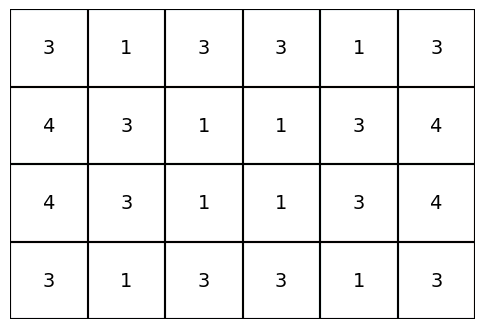

In [4]:
m = 4
n = 6
fig, ax = plt.subplots(figsize=(6, 9))

for i in range(m+1):
    ax.plot([0, n], [i, i])
for j in range(n+1):
    ax.plot([j, j], [0, m])

for i in range(m):
    for j in range(n):
        ax.text(j + 0.5, i + 0.5, str(gmap[i, j]),
                ha='center', va='center',
                fontsize=14)

ax.set_xlim(0, n)
ax.set_ylim(0, m)
ax.set_aspect('equal')
ax.invert_yaxis()   
ax.hlines(range(m+1), 0, n, colors='black')
ax.vlines(range(n+1), 0, m, colors='black')
ax.axis('off')

plt.show()